# Instalación de librerias.

In [1]:
!pip install boto3
!pip install tensorflow
!pip install tensorflow --upgrade

     |████████████████████████████████| 133kB 3.1MB/s 
     |████████████████████████████████| 81kB 6.2MB/s 
     |████████████████████████████████| 7.6MB 15.3MB/s 
     |████████████████████████████████| 143kB 48.0MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.5 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
     |████████████████████████████████| 133kB 3.0MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.26.5
    Uninstalling urllib3-1.26.5:
      Successfully uninstalled urllib3-1.26.5
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.7/dist-packages (2.5.0)


# Activo la libreria de drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Verificacion tecnica del sistema.



In [2]:
from platform import python_version
import tensorflow as tf

print("Version de python: " + python_version())
print("Version de tensorflow: " + tf.__version__)

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Version de python: 3.7.10
Version de tensorflow: 2.5.0
Wed Jun  2 04:21:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    33W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                 

# Carga del dataset.

In [3]:
from glob import glob

path_train = '/content/drive/MyDrive/AgricultureVisión/Data/dataset-estadistica-tfrecord/dataset-estadistica-train-rgb/'
train_filenames=(glob(path_train+'*.tfrecords'))
train_filenames
#train_filenames = '/content/drive/MyDrive/AgricultureVisión/Data/dataset-mineria-tfrecord/dataset-mineria-train-rgb.tfrecords'

['/content/drive/MyDrive/AgricultureVisión/Data/dataset-estadistica-tfrecord/dataset-estadistica-train-rgb/dataset-estadistica-train-rgb.tfrecords-part-1.tfrecords',
 '/content/drive/MyDrive/AgricultureVisión/Data/dataset-estadistica-tfrecord/dataset-estadistica-train-rgb/dataset-estadistica-train-rgb.tfrecords-part-0.tfrecords']

In [4]:
path_test = '/content/drive/MyDrive/AgricultureVisión/Data/dataset-estadistica-tfrecord/dataset-estadistica-test-rgb/'
test_filenames=(glob(path_test+'*.tfrecords'))
test_filenames
#test_filenames = '/content/drive/MyDrive/AgricultureVisión/Data/dataset-estadistica-tfrecord/dataset-estadistica-test-rgb.tfrecords'

['/content/drive/MyDrive/AgricultureVisión/Data/dataset-estadistica-tfrecord/dataset-estadistica-test-rgb/dataset-estadistica-test-rgb.tfrecords-part-0.tfrecords']

In [5]:
import os
import pandas as pd

pathClases = '/content/drive/MyDrive/AgricultureVisión/Data/dataset-estadistica/train/rgb'

classes = os.listdir(pathClases)

aux = []
for _idx, _valor in enumerate(classes):
    Class = _valor
    label = (classes.index(_valor))
    aux.append([Class, label])
    
csv = pd.DataFrame(aux, columns=['Class','label'])
csv.head(10)

,Class,label
0,double_plant,0
1,drydown,1
2,endrow,2
3,planter_skip,3
4,nutrient_deficiency,4
5,storm_damage,5
6,water,6
7,waterway,7
8,weed_cluster,8


In [6]:
#Tamaño de las imágenes en los archivos TFRecord
IMAGE_SIZE=[512,512]
CLASSES=list(csv['Class'])
print(CLASSES)
NO_OF_CLASSES=len(CLASSES)
NO_OF_CLASSES

['double_plant', 'drydown', 'endrow', 'planter_skip', 'nutrient_deficiency', 'storm_damage', 'water', 'waterway', 'weed_cluster']


9

In [7]:
# Funciones utilies.
import math
from matplotlib import pyplot as plt
import tensorflow as tf

AUTO = tf.data.experimental.AUTOTUNE
ignore_order = tf.data.Options()
ignore_order.experimental_deterministic = False

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convertir la imagen en flotantes en el rango [0, 1]
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # tamaño explícito necesario para el TPU
    return image

def read_tfrecord(example):
    features={
            "image_raw": tf.io.FixedLenFeature([], tf.string),
            "label": tf.io.FixedLenFeature([], tf.int64),}
    example = tf.io.parse_single_example(example, features)
    image = decode_image(example['image_raw'])
    label = tf.cast(example['label'], tf.int32)
    return image, label

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct
                                
def load_dataset(filenames,shuffle,BATCH_SIZE,repeat=False):
    # Leer desde TFRecords. Para un rendimiento óptimo, lea de varios
    # Archivos TFRecord a la vez y establecer la opción experimental_deterministic = False
    # para permitir optimizaciones que alteren el orden.
    dataset = tf.data.TFRecordDataset(filenames,num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_tfrecord)
    dataset = dataset.prefetch(AUTO)
    dataset = dataset.shuffle(shuffle)
    if(repeat):
        dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

def display_batch_of_images(databatch, predictions=None):
    """Esto funcionará con:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-cuadrado: esto eliminará los datos que no encajen en un cuadrado o rectángulo.
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # tamaño y espaciado
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # mostrar
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # fórmula mágica probada para trabajar de 1x1 a 10x10 imágenes
        subplot = display_one(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #diseño
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # cadena binaria en este caso, se trata de cadenas de identificación de imágenes.
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # Si no hay etiquetas, sólo los ID de las imágenes, devuelve None para las etiquetas (este es el caso de los datos de prueba)
    return numpy_images, numpy_labels

def display_one(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

In [9]:
#Mostrar algunas imágenes del conjunto de datos de entrenamiento.
# d=load_dataset(train_filenames,5000,30)
# train_batch=iter(d)
# display_batch_of_images(next(train_batch))

# Definir la estrategia de distribución
Creamos un objeto tipo MirroredStrategy. Esto manejará la distribución, y proporciona un gestor de contexto (tf.distribute.MirroredStrategy.scope) para construir su modelo dentro.

In [8]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [9]:
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


## Cuando se entrena un modelo con varias GPU, se puede utilizar la potencia de cálculo adicional de forma eficaz aumentando el tamaño del lote. En general, utilice el mayor tamaño de lote que se ajuste a la memoria de la GPU y ajuste la tasa de aprendizaje en consecuencia.

In [10]:
BUFFER_SIZE = 32

BATCH_SIZE_PER_REPLICA = 64
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

In [12]:
shuffle=5000
train_dataset=load_dataset(train_filenames,shuffle,BATCH_SIZE,True)
test_dataset=load_dataset(test_filenames,int(shuffle*0.5),BATCH_SIZE)

In [24]:
import keras.backend as K

K.clear_session()

def build_model(num_classes, img_size=512):
  with strategy.scope():
    input = tf.keras.layers.Input(shape=(img_size, img_size, 3))
    model = tf.keras.applications.NASNetLarge(include_top=False, input_tensor=input, weights="imagenet")

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    
    x = tf.keras.layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    output = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)

    
    for layer in model.layers[:-1]:
      layer.trainable = False
    
    #model.summary()
    # Compile
    model = tf.keras.Model(input, output, name="NASNetLarge")
    model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
    return model  

# Definir las llamadas de retorno
Los callbacks utilizados aquí son:



*   TensorBoard: Este callback escribe un registro para TensorBoard que permite visualizar las gráficas.
*   Model Checkpoint: Este callback guarda el modelo después de cada época.
*   Learning Rate Scheduler "Programador de la tasa de aprendizaje": Usando este callback, puedes programar la tasa de aprendizaje para que cambie después de cada epoch/lote.








In [25]:
# Define the checkpoint directory to store the checkpoints

checkpoint_dir = '/content/drive/MyDrive/AgricultureVisión/models/callbacks/training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

# Function for decaying the learning rate.
# You can define any decay function you need.
def decay(epoch):
  if epoch < 3:
    return 1e-3
  elif epoch >= 3 and epoch < 7:
    return 1e-4
  else:
    return 1e-5

# Callback for printing the LR at the end of each epoch.
# class PrintLR(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs=None):
#     print('\nTasa de aprendizaje para la época {} is {}'.format(epoch + 1,
#                                                       model.optimizer.lr.numpy()))

In [26]:
callbacks_list = [
    tf.keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/AgricultureVisión/models/callbacks/logs'),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                       save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

In [17]:
num_imagenes = glob(pathClases + '/*/*')

num_classes = 9
num_images = len(num_imagenes)
#num_images = 70500

model = build_model(num_classes)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [18]:
import time
import math

inicio = time.time()
history = model.fit(train_dataset,
                    validation_data=test_dataset,
                    batch_size=32, epochs=50,
                    steps_per_epoch=math.ceil(num_images/32),
                    callbacks=callbacks_list)

fin = time.time()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/50
34/34 [==============================] - 144s 3s/step - loss: 1.1629 - sparse_categorical_accuracy: 0.5993 - val_loss: 1.7437 - val_sparse_categorical_accuracy: 0.4711

Tasa de aprendizaje para la época 1 is 0.0010000000474974513
Epoch 2/50
34/34 [==============================] - 100s 3s/step - loss: 0.3948 - sparse_categorical_accuracy: 0.8709 - val_loss: 1.6480 - val_sparse_categorical_accuracy: 0.4867

Tasa de aprendizaje para la época 2 is 0.0010000000474974513
Epoch 3/50
34/34 [==============================] - 100s 3s/step - loss: 0.2309 - sparse_categorical_accuracy: 0.9347 - val_loss: 1.5452 - val_sparse_categorical_accuracy: 0.5378

Tasa de aprendizaje para la época 3 is 0.0010000000474974513
Epoch 4/50
34/34 [==============================] - 100s 3s/step - loss: 0.1636 - sparse_categorical_accuracy: 0.9655 - val_loss: 1.4745 - val_sparse_categorical_accuracy: 0.5556

Tasa de aprendizaje para la época 4 is 9.999999747378752e-05
Epoch 5/50
34/34 [==================

In [19]:
print("Tiempo de entrenamiento gpu tfrecord " + str((fin-inicio)/60) + " minutos")

Tiempo de entrenamiento gpu tfrecord 86.54945360819498 minutos


In [20]:
def plotTraining(hist, epochs, typeData):
    
    if typeData=="loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['loss']
        xc=range(epochs)
        plt.ylabel('Costo', fontsize=24)
        plt.plot(xc,yc,'-r',label='Costo entrenamiento')
    if typeData=="sparse_categorical_accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['sparse_categorical_accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'-r',label='Accuracy entrenamiento')
    if typeData=="val_loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['val_loss']
        xc=range(epochs)
        plt.ylabel('Costo', fontsize=24)
        plt.plot(xc,yc,'--b',label='Validación costo')
    if typeData=="val_sparse_categorical_accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['val_sparse_categorical_accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'--b',label='Validación accuracy')
        

    plt.rc('xtick',labelsize=24)
    plt.rc('ytick',labelsize=24)
    plt.rc('legend', fontsize=18) 
    plt.legend()
    plt.xlabel('Numero de epocas',fontsize=24)
    plt.grid(True)

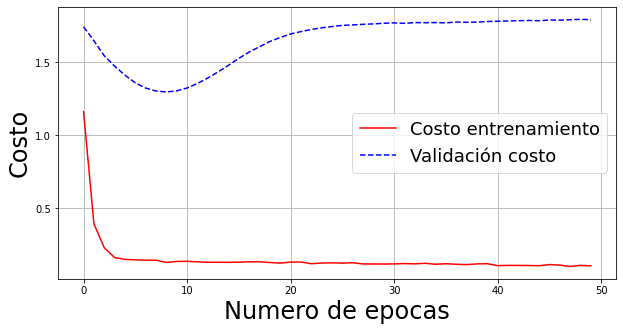

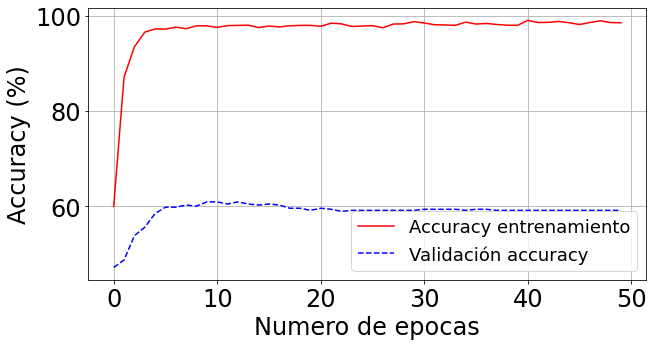

In [21]:
epochs = 50
plotTraining(history,epochs,"loss")
plotTraining(history,epochs,"sparse_categorical_accuracy")
plotTraining(history,epochs,"val_loss")
plotTraining(history,epochs,"val_sparse_categorical_accuracy")

In [22]:
from tensorflow.keras.models import load_model

model.save('/content/drive/MyDrive/AgricultureVisión/notebooks/mineria/Model/nasnet_50epo_tfrecord_strategy.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [27]:
import time
import math

inicio = time.time()
history = model.fit(train_dataset,
                    validation_data=test_dataset,
                    batch_size=32, epochs=10,
                    steps_per_epoch=math.ceil(num_images/32),
                    callbacks=callbacks_list)

fin = time.time()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/10
34/34 [==============================] - 107s 3s/step - loss: 0.1055 - sparse_categorical_accuracy: 0.9821 - val_loss: 1.9535 - val_sparse_categorical_accuracy: 0.5867

Tasa de aprendizaje para la época 1 is 0.0010000000474974513
Epoch 2/10
34/34 [==============================] - 100s 3s/step - loss: 0.0709 - sparse_categorical_accuracy: 0.9908 - val_loss: 2.0503 - val_sparse_categorical_accuracy: 0.5889

Tasa de aprendizaje para la época 2 is 0.0010000000474974513
Epoch 3/10
34/34 [==============================] - 100s 3s/step - loss: 0.0539 - sparse_categorical_accuracy: 0.9903 - val_loss: 2.2499 - val_sparse_categorical_accuracy: 0.5933

Tasa de aprendizaje para la época 3 is 0.0010000000474974513
Epoch 4/10
34/34 [==============================] - 100s 3s/step - loss: 0.0428 - sparse_categorical_accuracy: 0.9972 - val_loss: 2.1938 - val_sparse_categorical_accuracy: 0.6089

Tasa de aprendizaje para la época 4 is 9.999999747378752e-05
Epoch 5/10
34/34 [==================

In [28]:
print("Tiempo de entrenamiento gpu tfrecord " + str((fin-inicio)/60) + " minutos")

Tiempo de entrenamiento gpu tfrecord 17.39122858842214 minutos


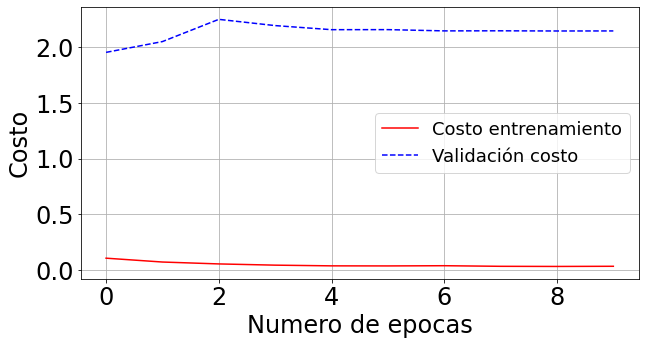

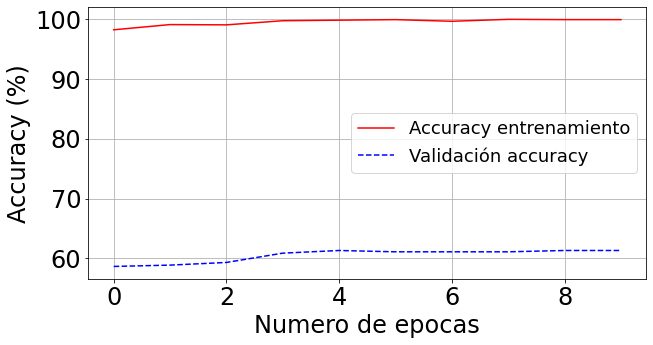

In [29]:
epochs = 10
plotTraining(history,epochs,"loss")
plotTraining(history,epochs,"sparse_categorical_accuracy")
plotTraining(history,epochs,"val_loss")
plotTraining(history,epochs,"val_sparse_categorical_accuracy")

In [30]:
from tensorflow.keras.models import load_model

model.save('/content/drive/MyDrive/AgricultureVisión/notebooks/mineria/Model/nasnet_10epo_tfrecord_strategy.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
#Display predicted images in test set
numero_imagenes_ = 20
valid=load_dataset(test_filenames,5000,numero_imagenes_)
valid=next(iter(valid))
result=model.predict(valid[0])
display_batch_of_images(valid,predictions=tf.argmax(result,axis=1))